In [1]:
from PIL import Image
import numpy as np
import gym
import gym_snake

from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, \
    Convolution2D, Permute, Input, Lambda
from keras.optimizers import Adam
import keras.backend as K

from keras.models import model_from_config
import tensorflow as tf
from collections import deque
import random

from IPython.display import display
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
ENV_NAME = 'snake-v0'  # Environment name
FRAME_WIDTH = 84  # Resized frame width
FRAME_HEIGHT = 84  # Resized frame height
INPUT_SHAPE = (FRAME_WIDTH, FRAME_HEIGHT)
WINDOW_LENGTH = 4  # Number of most recent frames to produce the input to the network (WINDOW LENGTH)


In [4]:

NUM_STEPS = 4_000_005

EXPLORATION_STEPS = 2_000_005  # Number of steps over which the initial value # of epsilon is linearly annealed to its final value
INITIAL_EPSILON = 1.0  # Initial value of epsilon in epsilon-greedy
FINAL_EPSILON = 0.1  # Final value of epsilon in epsilon-greedy

OBSERVE = 20_000  # Number of steps to populate the replay memory before training starts
NUM_REPLAY_MEMORY = 400_000  # Number of replay memory the agent uses for training
BATCH_SIZE = 32  # Mini batch size
TARGET_UPDATE_INTERVAL = 10_000  # The frequency with which the target network is updated
TRAIN_INTERVAL = 4  # The agent selects 4 actions between successive updates

LEARNING_RATE = 0.00025  # Learning rate used by optimizer
GAMMA = 0.99  # Discount factor

SAVE_INTERVAL = 200_000  # The frequency with which the network is saved
NO_OP_STEPS = 7  # Maximum number of "do nothing" actions to be performed by the agent at the start of an episode

SAVE_NETWORK_PATH = 'saved_networks/' + ENV_NAME
SAVE_SUMMARY_PATH = 'summary/' + ENV_NAME


In [5]:
def get_env():
    env = gym.make(ENV_NAME)
    env.n_foods = 3
    env.grid_size = [20, 20]
    env.unit_size = 10
    env.unit_gap = 1
    env.wall = True
    env.random_init = True
    return env

Grid Size:  [20 20]
Image shape before pre-processing:  (200, 200, 3)
Image shape after pre-processing:  (84, 84)
No. of actions:  4

Before Preprocessing:


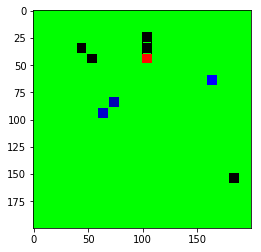


After Preprocessing:


/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ankur/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


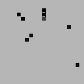

<Figure size 432x288 with 0 Axes>

In [6]:
env = get_env()
x_t = env.reset()

# Controller
game_controller = env.controller
# Grid
grid_object = game_controller.grid
grid_pixels = grid_object.grid
print('Grid Size: ', grid_object.grid_size)
# Snake(s)
snakes_array = game_controller.snakes
snake_object1 = snakes_array[0]

state_shape = grid_pixels.shape
print('Image shape before pre-processing: ', state_shape)
print('Image shape after pre-processing: ', (FRAME_WIDTH, FRAME_HEIGHT))
nb_actions = env.action_space.n
print('No. of actions: ', nb_actions)

print('\nBefore Preprocessing:')
env.render()

print('\nAfter Preprocessing:')

processed_image = np.uint8(resize(rgb2gray(x_t), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
img = Image.fromarray(processed_image)
display(img)

In [7]:
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE


def r(raw):
    raw = [f.reshape((1,) + INPUT_SHAPE) for f in raw]
    raw = np.asarray(raw).reshape(input_shape)
    raw = np.expand_dims(raw, axis=0)
    return raw


def process_observation(observation):
    assert observation.ndim == 3  # (height, width, channel)
    img = Image.fromarray(observation)
    img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
    processed_observation = np.array(img)
    assert processed_observation.shape == INPUT_SHAPE
    return processed_observation.astype('uint8') / 255.  # saves storage in experience memory


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)


def get_model():
    model = Sequential()
    if K.image_dim_ordering() == 'tf':
        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
    elif K.image_dim_ordering() == 'th':
        # (channels, width, height)
        model.add(Permute((1, 2, 3), input_shape=input_shape))
    else:
        raise RuntimeError('Unknown image_dim_ordering.')
    print('INPUT SHAPE: ', input_shape)
    model.add(Convolution2D(32, (8, 8), strides=(4, 4), trainable=False))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2), trainable=False))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    return model


model = get_model()
print(model.summary())
model.compile(loss=huber_loss, optimizer=Adam(lr=LEARNING_RATE), metrics=['mae'])

target_model = get_model()
target_model.compile(loss=huber_loss, optimizer=Adam(lr=LEARNING_RATE), metrics=['mae'])


def get_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(env.action_space.n)
    if random.random() < 0.5:
        act_values = model.predict(r(state))
    else:
        act_values = target_model.predict(r(state))
    return np.argmax(act_values[0])


def get_test_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(env.action_space.n)
    act_values = model.predict(r(state))
    return np.argmax(act_values[0])


def update_model():
    minibatch = random.sample(memory, BATCH_SIZE)
    total_loss = 0.
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            best_action = np.argmax(model.predict(r(next_state))[0])
            target = (reward + GAMMA * target_model.predict(r(next_state))[0][best_action])
        target_f = model.predict(r(state))
        target_f[0][action] = target
        h = model.fit(r(state), target_f, epochs=1, verbose=0)
        total_loss += h.history['loss'][0]
    return total_loss


def update_target():
    minibatch = random.sample(memory, BATCH_SIZE)
    total_loss = 0.
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            best_action = np.argmax(target_model.predict(r(next_state))[0])
            target = (reward + GAMMA * model.predict(r(next_state))[0][best_action])
        target_f = target_model.predict(r(state))
        target_f[0][action] = target
        h = model.fit(r(state), target_f, epochs=1, verbose=0)
        total_loss += h.history['loss'][0]
    return total_loss


def replay():
    if random.random() > 0.5:
        return update_target()
    else:
        return update_model()


def setup_summary():
    episode_total_reward = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Total_Reward/Episode', episode_total_reward)
    episode_avg_max_q = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Average_Max_Q/Episode', episode_avg_max_q)
    episode_duration = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Duration/Episode', episode_duration)
    episode_avg_loss = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Average_Loss/Episode', episode_avg_loss)
    epsilon = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Epsilon/Episode', epsilon)
    curr_time_step = tf.Variable(0.)
    tf.summary.scalar(ENV_NAME + '/Steps/Episode', curr_time_step)

    summary_vars = [episode_total_reward, episode_avg_max_q, episode_duration, episode_avg_loss, epsilon,
                    curr_time_step]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op
# def get_initial_state(self, observation):
#     processed_observation = np.uint8(resize(rgb2gray(observation), (FRAME_WIDTH, FRAME_HEIGHT)) * 255)
#     state = [processed_observation for _ in range(WINDOW_LENGTH)]
#     return np.stack(state, axis=0)


INPUT SHAPE:  (4, 84, 84)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)     

INPUT SHAPE:  (4, 84, 84)


In [9]:
model.load_weights('snake2 transfer learning/snake1_best.h5f')

for i in range(7):
    model.pop()

model.add(Convolution2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/4000005 [00:00<?, ?it/s]

  0%|          | 2/4000005 [00:00<62:02:11, 17.91it/s]

  0%|          | 11/4000005 [00:00<47:12:46, 23.53it/s]

  0%|          | 21/4000005 [00:00<36:35:27, 30.37it/s]

  0%|          | 32/4000005 [00:00<28:51:08, 38.51it/s]

  0%|          | 44/4000005 [00:00<23:10:29, 47.94it/s]

  0%|          | 54/4000005 [00:00<19:44:57, 56.26it/s]

  0%|          | 64/4000005 [00:00<17:24:57, 63.80it/s]

  0%|          | 76/4000005 [00:00<15:03:02, 73.82it/s]

EPISODE:      1 / TIMESTEP:       56 / DURATION:    57 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      2 / TIMESTEP:       63 / DURATION:     7 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 86/4000005 [00:00<13:58:19, 79.52it/s]

  0%|          | 98/4000005 [00:01<12:52:01, 86.35it/s]

EPISODE:      3 / TIMESTEP:       77 / DURATION:    14 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      4 / TIMESTEP:       81 / DURATION:     4 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      5 / TIMESTEP:       97 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 109/4000005 [00:01<12:18:07, 90.32it/s]

  0%|          | 120/4000005 [00:01<11:41:20, 95.05it/s]

  0%|          | 131/4000005 [00:01<11:29:12, 96.73it/s]

EPISODE:      6 / TIMESTEP:      110 / DURATION:    13 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      7 / TIMESTEP:      127 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 142/4000005 [00:01<11:08:03, 99.79it/s]

  0%|          | 154/4000005 [00:01<10:40:14, 104.12it/s]

EPISODE:      8 / TIMESTEP:      138 / DURATION:    11 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      9 / TIMESTEP:      157 / DURATION:    19 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 165/4000005 [00:01<10:41:12, 103.97it/s]

  0%|          | 176/4000005 [00:01<10:31:30, 105.56it/s]

  0%|          | 187/4000005 [00:01<10:25:23, 106.60it/s]

  0%|          | 200/4000005 [00:01<9:52:17, 112.55it/s] 

  0%|          | 212/4000005 [00:02<10:02:05, 110.72it/s]

  0%|          | 224/4000005 [00:02<9:56:50, 111.69it/s] 

EPISODE:     10 / TIMESTEP:      201 / DURATION:    44 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     11 / TIMESTEP:      219 / DURATION:    18 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 237/4000005 [00:02<9:34:34, 116.02it/s]

  0%|          | 250/4000005 [00:02<9:17:24, 119.60it/s]

  0%|          | 268/4000005 [00:02<8:30:21, 130.62it/s]

  0%|          | 283/4000005 [00:02<8:15:51, 134.44it/s]

  0%|          | 297/4000005 [00:02<8:27:01, 131.48it/s]

  0%|          | 313/4000005 [00:02<8:00:39, 138.69it/s]

  0%|          | 331/4000005 [00:02<7:34:57, 146.52it/s]

  0%|          | 346/4000005 [00:03<7:50:35, 141.65it/s]

EPISODE:     12 / TIMESTEP:      330 / DURATION:   111 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     13 / TIMESTEP:      333 / DURATION:     3 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 361/4000005 [00:03<7:50:57, 141.54it/s]

  0%|          | 376/4000005 [00:03<8:28:25, 131.11it/s]

EPISODE:     14 / TIMESTEP:      361 / DURATION:    28 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 390/4000005 [00:03<10:11:28, 109.02it/s]

  0%|          | 402/4000005 [00:03<10:00:46, 110.96it/s]

  0%|          | 414/4000005 [00:03<10:42:37, 103.73it/s]

  0%|          | 425/4000005 [00:03<11:06:34, 100.00it/s]

  0%|          | 436/4000005 [00:03<11:16:24, 98.55it/s] 

  0%|          | 450/4000005 [00:04<10:33:53, 105.16it/s]

  0%|          | 463/4000005 [00:04<10:04:16, 110.31it/s]

  0%|          | 480/4000005 [00:04<9:01:05, 123.19it/s] 

  0%|          | 499/4000005 [00:04<8:10:37, 135.86it/s]

EPISODE:     15 / TIMESTEP:      471 / DURATION:   110 / EPSILON: 1.00000 / TOTAL_REWARD:   4 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 514/4000005 [00:04<8:12:02, 135.47it/s]

  0%|          | 529/4000005 [00:04<8:52:36, 125.15it/s]

  0%|          | 543/4000005 [00:04<9:28:07, 117.33it/s]

  0%|          | 556/4000005 [00:04<9:51:53, 112.62it/s]

  0%|          | 568/4000005 [00:05<9:56:35, 111.73it/s]

  0%|          | 581/4000005 [00:05<9:31:40, 116.60it/s]

  0%|          | 594/4000005 [00:05<9:21:36, 118.69it/s]

EPISODE:     16 / TIMESTEP:      569 / DURATION:    98 / EPSILON: 1.00000 / TOTAL_REWARD:   1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 607/4000005 [00:05<9:37:22, 115.45it/s]

  0%|          | 619/4000005 [00:05<9:53:38, 112.28it/s]

  0%|          | 631/4000005 [00:05<9:43:58, 114.14it/s]

EPISODE:     17 / TIMESTEP:      611 / DURATION:    42 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 643/4000005 [00:05<10:01:20, 110.84it/s]

  0%|          | 655/4000005 [00:05<10:10:55, 109.11it/s]

  0%|          | 668/4000005 [00:05<9:43:23, 114.25it/s] 

EPISODE:     18 / TIMESTEP:      647 / DURATION:    36 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     19 / TIMESTEP:      661 / DURATION:    14 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 680/4000005 [00:05<9:56:24, 111.76it/s]

  0%|          | 692/4000005 [00:06<10:18:07, 107.83it/s]

EPISODE:     20 / TIMESTEP:      677 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 705/4000005 [00:06<9:56:33, 111.73it/s] 

  0%|          | 718/4000005 [00:06<9:41:09, 114.69it/s]

  0%|          | 730/4000005 [00:06<9:45:29, 113.84it/s]

  0%|          | 744/4000005 [00:06<9:23:23, 118.31it/s]

EPISODE:     21 / TIMESTEP:      718 / DURATION:    41 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     22 / TIMESTEP:      727 / DURATION:     9 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     23 / TIMESTEP:      743 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 756/4000005 [00:06<9:59:34, 111.17it/s]

  0%|          | 768/4000005 [00:06<9:59:52, 111.11it/s]

  0%|          | 780/4000005 [00:06<10:57:39, 101.35it/s]

  0%|          | 791/4000005 [00:07<12:02:59, 92.19it/s] 

  0%|          | 801/4000005 [00:07<12:48:41, 86.71it/s]

  0%|          | 810/4000005 [00:07<12:56:40, 85.82it/s]

EPISODE:     24 / TIMESTEP:      796 / DURATION:    53 / EPSILON: 1.00000 / TOTAL_REWARD:   1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     25 / TIMESTEP:      805 / DURATION:     9 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 820/4000005 [00:07<12:40:03, 87.69it/s]

  0%|          | 829/4000005 [00:07<12:59:26, 85.51it/s]

  0%|          | 839/4000005 [00:07<12:28:17, 89.07it/s]

EPISODE:     26 / TIMESTEP:      824 / DURATION:    19 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 852/4000005 [00:07<11:21:56, 97.74it/s]

  0%|          | 865/4000005 [00:07<10:34:52, 104.99it/s]

  0%|          | 877/4000005 [00:07<10:22:42, 107.04it/s]

  0%|          | 888/4000005 [00:08<10:31:26, 105.56it/s]

  0%|          | 902/4000005 [00:08<9:48:05, 113.33it/s] 

EPISODE:     27 / TIMESTEP:      877 / DURATION:    53 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 914/4000005 [00:08<9:48:33, 113.24it/s]

  0%|          | 927/4000005 [00:08<9:26:13, 117.71it/s]

EPISODE:     28 / TIMESTEP:      911 / DURATION:    34 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 941/4000005 [00:08<9:07:07, 121.82it/s]

  0%|          | 954/4000005 [00:08<9:22:21, 118.52it/s]

  0%|          | 966/4000005 [00:08<9:46:32, 113.63it/s]

EPISODE:     29 / TIMESTEP:      955 / DURATION:    44 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     30 / TIMESTEP:      971 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 978/4000005 [00:08<9:52:44, 112.45it/s]

  0%|          | 990/4000005 [00:08<10:07:28, 109.72it/s]

  0%|          | 1002/4000005 [00:09<10:30:01, 105.79it/s]

  0%|          | 1014/4000005 [00:09<10:09:17, 109.39it/s]

EPISODE:     31 / TIMESTEP:      995 / DURATION:    24 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1026/4000005 [00:09<9:56:50, 111.67it/s] 

  0%|          | 1039/4000005 [00:09<9:36:24, 115.63it/s]

EPISODE:     32 / TIMESTEP:     1018 / DURATION:    23 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1051/4000005 [00:09<10:22:55, 106.99it/s]

  0%|          | 1063/4000005 [00:09<10:07:32, 109.70it/s]

  0%|          | 1075/4000005 [00:09<10:08:52, 109.46it/s]

  0%|          | 1087/4000005 [00:09<10:00:30, 110.99it/s]

  0%|          | 1100/4000005 [00:09<9:39:40, 114.98it/s] 

EPISODE:     33 / TIMESTEP:     1077 / DURATION:    59 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     34 / TIMESTEP:     1094 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1112/4000005 [00:09<9:44:16, 114.07it/s]

  0%|          | 1128/4000005 [00:10<8:58:36, 123.74it/s]

  0%|          | 1146/4000005 [00:10<8:10:50, 135.78it/s]

  0%|          | 1161/4000005 [00:10<8:47:28, 126.35it/s]

  0%|          | 1175/4000005 [00:10<9:06:50, 121.88it/s]

EPISODE:     35 / TIMESTEP:     1154 / DURATION:    60 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     36 / TIMESTEP:     1171 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1188/4000005 [00:10<9:04:01, 122.51it/s]

  0%|          | 1201/4000005 [00:10<9:02:11, 122.92it/s]

  0%|          | 1214/4000005 [00:10<9:08:50, 121.43it/s]

  0%|          | 1227/4000005 [00:10<9:45:27, 113.84it/s]

  0%|          | 1239/4000005 [00:11<9:40:52, 114.73it/s]

EPISODE:     37 / TIMESTEP:     1221 / DURATION:    50 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1251/4000005 [00:11<9:37:44, 115.35it/s]

  0%|          | 1265/4000005 [00:11<9:11:20, 120.88it/s]

  0%|          | 1281/4000005 [00:11<8:31:15, 130.35it/s]

  0%|          | 1297/4000005 [00:11<8:10:24, 135.90it/s]

  0%|          | 1312/4000005 [00:11<7:56:56, 139.73it/s]

EPISODE:     38 / TIMESTEP:     1288 / DURATION:    67 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1327/4000005 [00:11<8:00:53, 138.59it/s]

  0%|          | 1344/4000005 [00:11<7:39:00, 145.19it/s]

  0%|          | 1360/4000005 [00:11<7:27:31, 148.92it/s]

  0%|          | 1376/4000005 [00:11<7:38:07, 145.47it/s]

  0%|          | 1392/4000005 [00:12<7:27:48, 148.82it/s]

EPISODE:     39 / TIMESTEP:     1363 / DURATION:    75 / EPSILON: 1.00000 / TOTAL_REWARD:   3 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     40 / TIMESTEP:     1364 / DURATION:     1 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1407/4000005 [00:12<7:44:09, 143.58it/s]

  0%|          | 1422/4000005 [00:12<7:40:59, 144.56it/s]

EPISODE:     41 / TIMESTEP:     1402 / DURATION:    38 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     42 / TIMESTEP:     1410 / DURATION:     8 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1437/4000005 [00:12<7:43:43, 143.71it/s]

  0%|          | 1452/4000005 [00:12<7:38:06, 145.47it/s]

  0%|          | 1469/4000005 [00:12<7:20:54, 151.15it/s]

  0%|          | 1485/4000005 [00:12<7:24:38, 149.88it/s]

  0%|          | 1502/4000005 [00:12<7:09:22, 155.21it/s]

EPISODE:     43 / TIMESTEP:     1509 / DURATION:    99 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


KeyboardInterrupt: 

In [ ]:
memory = deque(maxlen=NUM_REPLAY_MEMORY)
state = deque(maxlen=WINDOW_LENGTH)

env = get_env()
observation = env.reset()
observation = process_observation(observation)
state.append(observation)
state.append(observation)
state.append(observation)
state.append(observation)

current = [observation for _ in range(WINDOW_LENGTH)]
previous = [observation for _ in range(WINDOW_LENGTH)]

# Parameters used for summary
total_reward = 0.
total_q_max = 0.
total_loss = 0.
duration = 0
episode = 0

sess = tf.InteractiveSession()
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter(SAVE_SUMMARY_PATH, sess.graph)
sess.run(tf.initialize_all_variables())
epsilon = INITIAL_EPSILON

for t in tqdm(range(NUM_STEPS)):
    action = get_action(current, epsilon)

    observation, reward, terminal, _ = env.step(int(action))
    observation = process_observation(observation)
    total_reward += reward
    duration += 1

    total_q_max += np.argmax(model.predict(r(state)))
    state.append(observation)

    # Remember
    current = list(state)
    memory.append((previous, action, reward, current, terminal))
    previous = current

    if t > OBSERVE:
        # Train
        if t % TRAIN_INTERVAL == 0:
            total_loss += replay()
        
        # Save Weights Interval
        if t % SAVE_INTERVAL == 0:
            model.save_weights((SAVE_NETWORK_PATH + '/snake2_tl_{}.h5').format(t))
    
        # Update Target Network
        if t % TARGET_UPDATE_INTERVAL == 0:
            target_model.set_weights(model.get_weights())
        
        # Exploration Rate Decay
        if epsilon > FINAL_EPSILON:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORATION_STEPS

    # End of episode
    if terminal:
        # Writing Summary Log
        avg_q = total_q_max / float(duration)
        avg_loss = total_loss / (float(duration) / float(TRAIN_INTERVAL))
        if t >= OBSERVE:
            stats = [total_reward, avg_q, duration, avg_loss, float(epsilon), float(t)]

            for i in range(len(stats)):
                sess.run(update_ops[i], feed_dict={
                    summary_placeholders[i]: float(stats[i])
                })
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, episode + 1)

        # Debug
        if t < OBSERVE:
            mode = 'random'
        elif OBSERVE <= t < OBSERVE + EXPLORATION_STEPS:
            mode = 'explore'
        else:
            mode = 'exploit'
        print(
            'EPISODE: {0:6d} / TIMESTEP: {1:8d} / DURATION: {2:5d} /'
            ' EPSILON: {3:.5f} / TOTAL_REWARD: {4:3.0f} / '
            'AVG_MAX_Q: {5:2.4f} / AVG_LOSS: {6:.5f} / MODE: {7}'.format(
                episode + 1, t, duration, epsilon,
                total_reward, avg_q, avg_loss, mode))

        total_reward = 0.
        total_q_max = 0.
        total_loss = 0.
        duration = 0
        episode += 1

        observation = env.reset()
        for _ in range(random.randint(1, NO_OP_STEPS)):
            observation, _, terminal, _ = env.step(env.action_space.sample())  # Do nothing
            if terminal:
                observation = env.reset()
                break
        observation = process_observation(observation)
        state = deque(maxlen=WINDOW_LENGTH)
        state.append(observation)
        state.append(observation)
        state.append(observation)
        state.append(observation)
        current = [observation for i in range(4)]
        previous = [observation for i in range(4)]

model.save_weights(SAVE_NETWORK_PATH + '/snake2_tl_final.h5')

Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/4000005 [00:00<?, ?it/s]

  0%|          | 2/4000005 [00:00<62:02:11, 17.91it/s]

  0%|          | 11/4000005 [00:00<47:12:46, 23.53it/s]

  0%|          | 21/4000005 [00:00<36:35:27, 30.37it/s]

  0%|          | 32/4000005 [00:00<28:51:08, 38.51it/s]

  0%|          | 44/4000005 [00:00<23:10:29, 47.94it/s]

  0%|          | 54/4000005 [00:00<19:44:57, 56.26it/s]

  0%|          | 64/4000005 [00:00<17:24:57, 63.80it/s]

  0%|          | 76/4000005 [00:00<15:03:02, 73.82it/s]

EPISODE:      1 / TIMESTEP:       56 / DURATION:    57 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      2 / TIMESTEP:       63 / DURATION:     7 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 86/4000005 [00:00<13:58:19, 79.52it/s]

  0%|          | 98/4000005 [00:01<12:52:01, 86.35it/s]

EPISODE:      3 / TIMESTEP:       77 / DURATION:    14 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      4 / TIMESTEP:       81 / DURATION:     4 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      5 / TIMESTEP:       97 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 109/4000005 [00:01<12:18:07, 90.32it/s]

  0%|          | 120/4000005 [00:01<11:41:20, 95.05it/s]

  0%|          | 131/4000005 [00:01<11:29:12, 96.73it/s]

EPISODE:      6 / TIMESTEP:      110 / DURATION:    13 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      7 / TIMESTEP:      127 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 142/4000005 [00:01<11:08:03, 99.79it/s]

  0%|          | 154/4000005 [00:01<10:40:14, 104.12it/s]

EPISODE:      8 / TIMESTEP:      138 / DURATION:    11 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:      9 / TIMESTEP:      157 / DURATION:    19 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 165/4000005 [00:01<10:41:12, 103.97it/s]

  0%|          | 176/4000005 [00:01<10:31:30, 105.56it/s]

  0%|          | 187/4000005 [00:01<10:25:23, 106.60it/s]

  0%|          | 200/4000005 [00:01<9:52:17, 112.55it/s] 

  0%|          | 212/4000005 [00:02<10:02:05, 110.72it/s]

  0%|          | 224/4000005 [00:02<9:56:50, 111.69it/s] 

EPISODE:     10 / TIMESTEP:      201 / DURATION:    44 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     11 / TIMESTEP:      219 / DURATION:    18 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 237/4000005 [00:02<9:34:34, 116.02it/s]

  0%|          | 250/4000005 [00:02<9:17:24, 119.60it/s]

  0%|          | 268/4000005 [00:02<8:30:21, 130.62it/s]

  0%|          | 283/4000005 [00:02<8:15:51, 134.44it/s]

  0%|          | 297/4000005 [00:02<8:27:01, 131.48it/s]

  0%|          | 313/4000005 [00:02<8:00:39, 138.69it/s]

  0%|          | 331/4000005 [00:02<7:34:57, 146.52it/s]

  0%|          | 346/4000005 [00:03<7:50:35, 141.65it/s]

EPISODE:     12 / TIMESTEP:      330 / DURATION:   111 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     13 / TIMESTEP:      333 / DURATION:     3 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 361/4000005 [00:03<7:50:57, 141.54it/s]

  0%|          | 376/4000005 [00:03<8:28:25, 131.11it/s]

EPISODE:     14 / TIMESTEP:      361 / DURATION:    28 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 390/4000005 [00:03<10:11:28, 109.02it/s]

  0%|          | 402/4000005 [00:03<10:00:46, 110.96it/s]

  0%|          | 414/4000005 [00:03<10:42:37, 103.73it/s]

  0%|          | 425/4000005 [00:03<11:06:34, 100.00it/s]

  0%|          | 436/4000005 [00:03<11:16:24, 98.55it/s] 

  0%|          | 450/4000005 [00:04<10:33:53, 105.16it/s]

  0%|          | 463/4000005 [00:04<10:04:16, 110.31it/s]

  0%|          | 480/4000005 [00:04<9:01:05, 123.19it/s] 

  0%|          | 499/4000005 [00:04<8:10:37, 135.86it/s]

EPISODE:     15 / TIMESTEP:      471 / DURATION:   110 / EPSILON: 1.00000 / TOTAL_REWARD:   4 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 514/4000005 [00:04<8:12:02, 135.47it/s]

  0%|          | 529/4000005 [00:04<8:52:36, 125.15it/s]

  0%|          | 543/4000005 [00:04<9:28:07, 117.33it/s]

  0%|          | 556/4000005 [00:04<9:51:53, 112.62it/s]

  0%|          | 568/4000005 [00:05<9:56:35, 111.73it/s]

  0%|          | 581/4000005 [00:05<9:31:40, 116.60it/s]

  0%|          | 594/4000005 [00:05<9:21:36, 118.69it/s]

EPISODE:     16 / TIMESTEP:      569 / DURATION:    98 / EPSILON: 1.00000 / TOTAL_REWARD:   1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 607/4000005 [00:05<9:37:22, 115.45it/s]

  0%|          | 619/4000005 [00:05<9:53:38, 112.28it/s]

  0%|          | 631/4000005 [00:05<9:43:58, 114.14it/s]

EPISODE:     17 / TIMESTEP:      611 / DURATION:    42 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 643/4000005 [00:05<10:01:20, 110.84it/s]

  0%|          | 655/4000005 [00:05<10:10:55, 109.11it/s]

  0%|          | 668/4000005 [00:05<9:43:23, 114.25it/s] 

EPISODE:     18 / TIMESTEP:      647 / DURATION:    36 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     19 / TIMESTEP:      661 / DURATION:    14 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 680/4000005 [00:05<9:56:24, 111.76it/s]

  0%|          | 692/4000005 [00:06<10:18:07, 107.83it/s]

EPISODE:     20 / TIMESTEP:      677 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 705/4000005 [00:06<9:56:33, 111.73it/s] 

  0%|          | 718/4000005 [00:06<9:41:09, 114.69it/s]

  0%|          | 730/4000005 [00:06<9:45:29, 113.84it/s]

  0%|          | 744/4000005 [00:06<9:23:23, 118.31it/s]

EPISODE:     21 / TIMESTEP:      718 / DURATION:    41 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     22 / TIMESTEP:      727 / DURATION:     9 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     23 / TIMESTEP:      743 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 756/4000005 [00:06<9:59:34, 111.17it/s]

  0%|          | 768/4000005 [00:06<9:59:52, 111.11it/s]

  0%|          | 780/4000005 [00:06<10:57:39, 101.35it/s]

  0%|          | 791/4000005 [00:07<12:02:59, 92.19it/s] 

  0%|          | 801/4000005 [00:07<12:48:41, 86.71it/s]

  0%|          | 810/4000005 [00:07<12:56:40, 85.82it/s]

EPISODE:     24 / TIMESTEP:      796 / DURATION:    53 / EPSILON: 1.00000 / TOTAL_REWARD:   1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     25 / TIMESTEP:      805 / DURATION:     9 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 820/4000005 [00:07<12:40:03, 87.69it/s]

  0%|          | 829/4000005 [00:07<12:59:26, 85.51it/s]

  0%|          | 839/4000005 [00:07<12:28:17, 89.07it/s]

EPISODE:     26 / TIMESTEP:      824 / DURATION:    19 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 852/4000005 [00:07<11:21:56, 97.74it/s]

  0%|          | 865/4000005 [00:07<10:34:52, 104.99it/s]

  0%|          | 877/4000005 [00:07<10:22:42, 107.04it/s]

  0%|          | 888/4000005 [00:08<10:31:26, 105.56it/s]

  0%|          | 902/4000005 [00:08<9:48:05, 113.33it/s] 

EPISODE:     27 / TIMESTEP:      877 / DURATION:    53 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 914/4000005 [00:08<9:48:33, 113.24it/s]

  0%|          | 927/4000005 [00:08<9:26:13, 117.71it/s]

EPISODE:     28 / TIMESTEP:      911 / DURATION:    34 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 941/4000005 [00:08<9:07:07, 121.82it/s]

  0%|          | 954/4000005 [00:08<9:22:21, 118.52it/s]

  0%|          | 966/4000005 [00:08<9:46:32, 113.63it/s]

EPISODE:     29 / TIMESTEP:      955 / DURATION:    44 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     30 / TIMESTEP:      971 / DURATION:    16 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 978/4000005 [00:08<9:52:44, 112.45it/s]

  0%|          | 990/4000005 [00:08<10:07:28, 109.72it/s]

  0%|          | 1002/4000005 [00:09<10:30:01, 105.79it/s]

  0%|          | 1014/4000005 [00:09<10:09:17, 109.39it/s]

EPISODE:     31 / TIMESTEP:      995 / DURATION:    24 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1026/4000005 [00:09<9:56:50, 111.67it/s] 

  0%|          | 1039/4000005 [00:09<9:36:24, 115.63it/s]

EPISODE:     32 / TIMESTEP:     1018 / DURATION:    23 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1051/4000005 [00:09<10:22:55, 106.99it/s]

  0%|          | 1063/4000005 [00:09<10:07:32, 109.70it/s]

  0%|          | 1075/4000005 [00:09<10:08:52, 109.46it/s]

  0%|          | 1087/4000005 [00:09<10:00:30, 110.99it/s]

  0%|          | 1100/4000005 [00:09<9:39:40, 114.98it/s] 

EPISODE:     33 / TIMESTEP:     1077 / DURATION:    59 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     34 / TIMESTEP:     1094 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1112/4000005 [00:09<9:44:16, 114.07it/s]

  0%|          | 1128/4000005 [00:10<8:58:36, 123.74it/s]

  0%|          | 1146/4000005 [00:10<8:10:50, 135.78it/s]

  0%|          | 1161/4000005 [00:10<8:47:28, 126.35it/s]

  0%|          | 1175/4000005 [00:10<9:06:50, 121.88it/s]

EPISODE:     35 / TIMESTEP:     1154 / DURATION:    60 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     36 / TIMESTEP:     1171 / DURATION:    17 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1188/4000005 [00:10<9:04:01, 122.51it/s]

  0%|          | 1201/4000005 [00:10<9:02:11, 122.92it/s]

  0%|          | 1214/4000005 [00:10<9:08:50, 121.43it/s]

  0%|          | 1227/4000005 [00:10<9:45:27, 113.84it/s]

  0%|          | 1239/4000005 [00:11<9:40:52, 114.73it/s]

EPISODE:     37 / TIMESTEP:     1221 / DURATION:    50 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1251/4000005 [00:11<9:37:44, 115.35it/s]

  0%|          | 1265/4000005 [00:11<9:11:20, 120.88it/s]

  0%|          | 1281/4000005 [00:11<8:31:15, 130.35it/s]

  0%|          | 1297/4000005 [00:11<8:10:24, 135.90it/s]

  0%|          | 1312/4000005 [00:11<7:56:56, 139.73it/s]

EPISODE:     38 / TIMESTEP:     1288 / DURATION:    67 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1327/4000005 [00:11<8:00:53, 138.59it/s]

  0%|          | 1344/4000005 [00:11<7:39:00, 145.19it/s]

  0%|          | 1360/4000005 [00:11<7:27:31, 148.92it/s]

  0%|          | 1376/4000005 [00:11<7:38:07, 145.47it/s]

  0%|          | 1392/4000005 [00:12<7:27:48, 148.82it/s]

EPISODE:     39 / TIMESTEP:     1363 / DURATION:    75 / EPSILON: 1.00000 / TOTAL_REWARD:   3 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     40 / TIMESTEP:     1364 / DURATION:     1 / EPSILON: 1.00000 / TOTAL_REWARD:   0 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1407/4000005 [00:12<7:44:09, 143.58it/s]

  0%|          | 1422/4000005 [00:12<7:40:59, 144.56it/s]

EPISODE:     41 / TIMESTEP:     1402 / DURATION:    38 / EPSILON: 1.00000 / TOTAL_REWARD:   2 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random
EPISODE:     42 / TIMESTEP:     1410 / DURATION:     8 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


  0%|          | 1437/4000005 [00:12<7:43:43, 143.71it/s]

  0%|          | 1452/4000005 [00:12<7:38:06, 145.47it/s]

  0%|          | 1469/4000005 [00:12<7:20:54, 151.15it/s]

  0%|          | 1485/4000005 [00:12<7:24:38, 149.88it/s]

  0%|          | 1502/4000005 [00:12<7:09:22, 155.21it/s]

EPISODE:     43 / TIMESTEP:     1509 / DURATION:    99 / EPSILON: 1.00000 / TOTAL_REWARD:  -1 / AVG_MAX_Q: 3.0000 / AVG_LOSS: 0.00000 / MODE: random


KeyboardInterrupt: 

In [8]:
%matplotlib
for e in tqdm(range(10)):
    state = deque(maxlen=WINDOW_LENGTH)
    env = get_env()
    observation = env.reset()
    observation = process_observation(observation)
    state.append(observation)
    state.append(observation)
    state.append(observation)
    state.append(observation)

    current = [observation for _ in range(WINDOW_LENGTH)]

    total_reward = 0.
    duration = 0
    episode = 0

    terminal = False
    while not terminal:
        action = get_test_action(current, 0.)
        # env.render()
        observation, reward, terminal, _ = env.step(int(action))
        observation = process_observation(observation)
        total_reward += reward
        duration += 1

        state.append(observation)

        # Remember
        current = list(state)

        if duration >= 600:
            print(duration)
            break

    print(total_reward, duration)


  0%|          | 0/10 [00:00<?, ?it/s]

Using matplotlib backend: Qt5Agg


 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

15.0 285


 20%|██        | 2/10 [00:01<00:08,  1.08s/it]

 30%|███       | 3/10 [00:01<00:05,  1.26it/s]

3.0 96
2.0 25


 40%|████      | 4/10 [00:02<00:05,  1.19it/s]

9.0 181


 50%|█████     | 5/10 [00:04<00:05,  1.07s/it]

12.0 360


 60%|██████    | 6/10 [00:05<00:04,  1.12s/it]

11.0 282


 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

4.0 122


 80%|████████  | 8/10 [00:06<00:01,  1.20it/s]

3.0 131


 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

6.0 213


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

10.0 216
